## Predicting House Prices - advanced regression techniques

### Initial loading of data

Loading of the training and testing data

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

In [315]:
import helper_functions

In [316]:
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [38]:
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))

Loaded 1460 training rows with 81 columns


In [5]:
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))

Loaded 1459 test rows with 80 columns


In [6]:
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

### Building a pipeline skeleton for all further steps

In [38]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

# class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)
    
class DFFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        # non-optimized default implementation; override when a better
        # method is possible
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for _, trans, weight in self._iter())
        return pd.concat(Xs, axis=1, join='inner')

### Testing the pipeline with a very simple model and only the numerical columns

In [48]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [11]:
predictions = pipeline.predict(X_test)

In [12]:
# Cleaning the predictions from 0 and below
predictions[predictions <= 0] = 0

In [15]:
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


### Eliminate right-skewed target variable

Analyzing the distribution of the target variable SalePrice

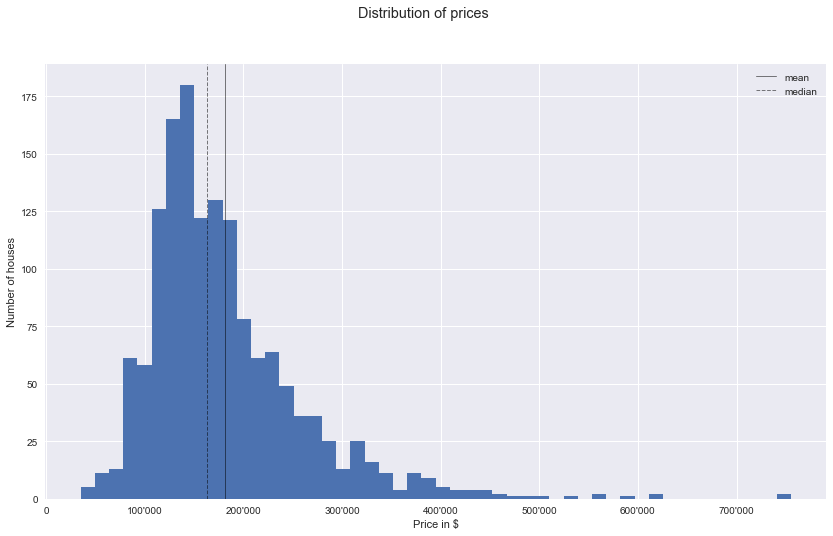

In [16]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. This gives us a much better distribution

In [17]:
y = np.log1p(y)

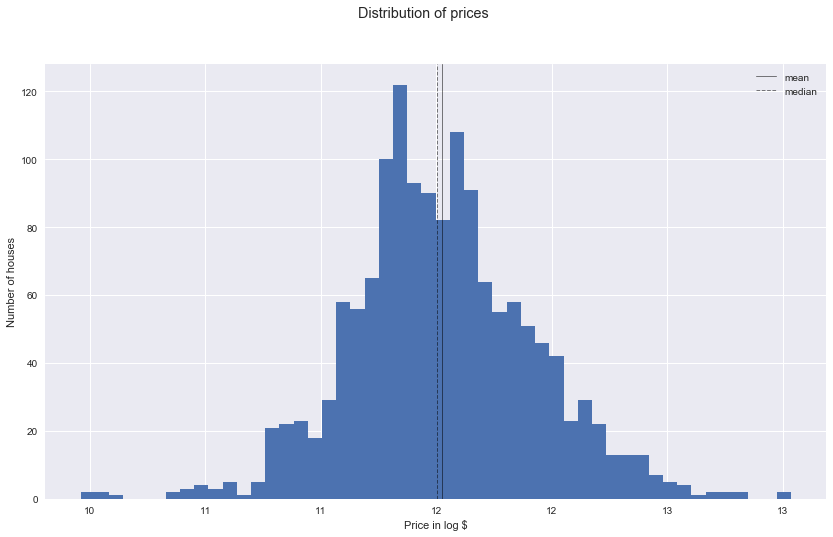

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in log $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

We now have a much better distribution and we test the pipeline with this new distributions.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [20]:
predictions = pipeline.predict(X_test)
predictions[predictions <= 0] = 0
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


We define a helper function for the process

In [298]:
def evaluate_pipeline(X_param, y_param, log_transform_param = False):
    X_train, X_test, y_train, y_test = train_test_split(X_param, y_param, test_size=.33, random_state=42)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    predictions[predictions <= 0] = 0
    print('here')
    print_benchmark(y_test, predictions, log_transform=log_transform_param)

In [46]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


### Eliminate outliers in the data

Accoring to the documentation there are some outliers present which we remove here after we examine their presence.

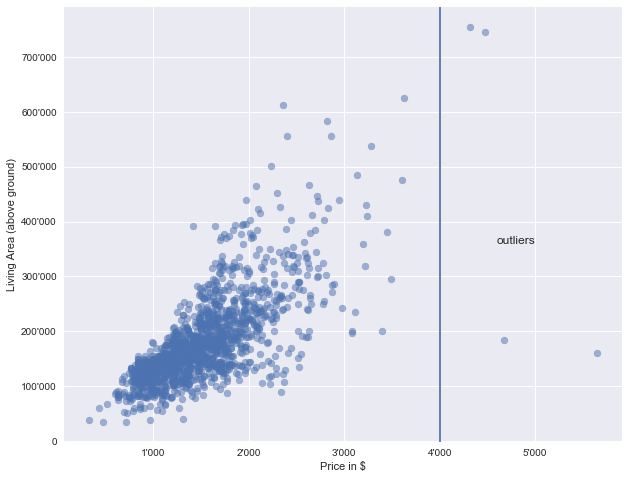

In [36]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(4000)
ax.text(4600, 360000, 'outliers')
plt.show()

In [63]:
outliers = X[X['GrLivArea'] >= 4000]

In [64]:
print('%s outliers to remove (%s)' % (len(outliers), outliers.index))

4 outliers to remove (Int64Index([523, 691, 1182, 1298], dtype='int64'))


In [117]:
X = X.drop(outliers.index)
y = y.drop(outliers.index)

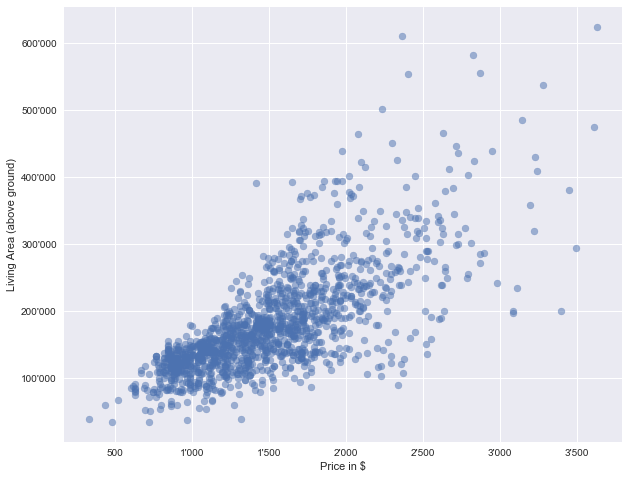

In [71]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(X['GrLivArea'], np.expm1(y), alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

We test the pipeline with the removed outliers therefore we need to select the numerical features only again because we are not ready for the encoding of those

In [118]:
# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

In [73]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.811045893083
RMSE (log): 0.17181598362314995


The score is a little bit better than with the outlies still in the dataset.

### Explore the direction of the data with principal component analysis

In [182]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_numerical)
X_numerical = scaler.transform(X_numerical)

In [183]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [184]:
print('Explained variance by the first 2 compoenents: %s' % pca.explained_variance_ratio_)

Explained variance by the first 2 compoenents: [ 0.18352898  0.09543763]


In [185]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

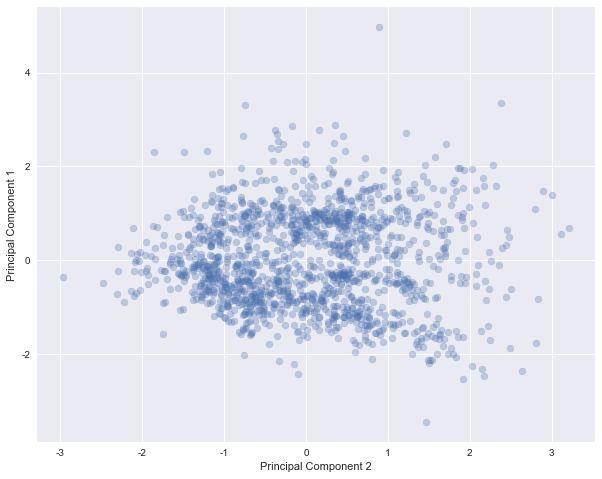

In [186]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax.set_ylabel('Principal Component 1')
ax.set_xlabel('Principal Component 2')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

But we want to analyse how many dimensions are in fact important

In [187]:
pca = PCA(whiten=True)
pca.fit(X_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [188]:
cumsum

array([ 0.18352898,  0.27896661,  0.34047822,  0.4002333 ,  0.44360774,
        0.47860357,  0.51257453,  0.54494628,  0.57681892,  0.6082521 ,
        0.63958738,  0.66920719,  0.69839373,  0.72673674,  0.75447223,
        0.78050718,  0.80556838,  0.82986338,  0.85368566,  0.87659745,
        0.89772237,  0.91577029,  0.93310012,  0.9468523 ,  0.95791541,
        0.96694865,  0.97516878,  0.98286013,  0.98869037,  0.99318327,
        0.9970844 ,  1.        ,  1.        ,  1.        ])

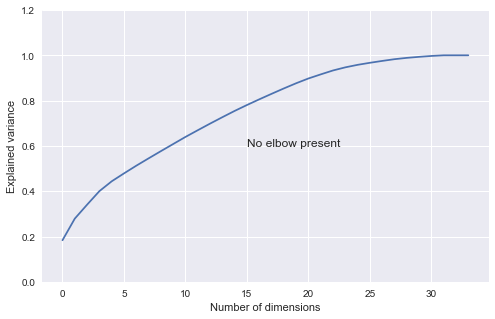

In [206]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumsum)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')
ax.set_ylim(0,1.2)
ax.text(15, .6, 'No elbow present')
plt.show()

pca = PCA(n_components=.95)
X_reduced = pca.fit_transform(X_numerical)

In [192]:
print('95 percent or more of the variance is eplained with %s component' % str(pca.n_components_))

95 percent or more of the variance is eplained with 25 component


With 25 components more than 95% of the variance of the data is explained.

In [196]:
X_reduced.shape

(1456, 25)

In [197]:
reduced_data = pd.DataFrame(X_reduced)

In [200]:
model = linear_model.LinearRegression()
model.fit(reduced_data, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [201]:
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(pca.transform(X_test_scaled))

In [202]:
print_benchmark(np.expm1(y_test), predictions, log_transform=True)

R2-score: 0.839405887716
RMSE (log): 0.2644742897313069


** Never forget ** :
You need to scale before doing principal component analysis

### Eliminate variables which hurt the non-coolinearity assumption

Based on the previous findings we look for variables which do correlate heavily

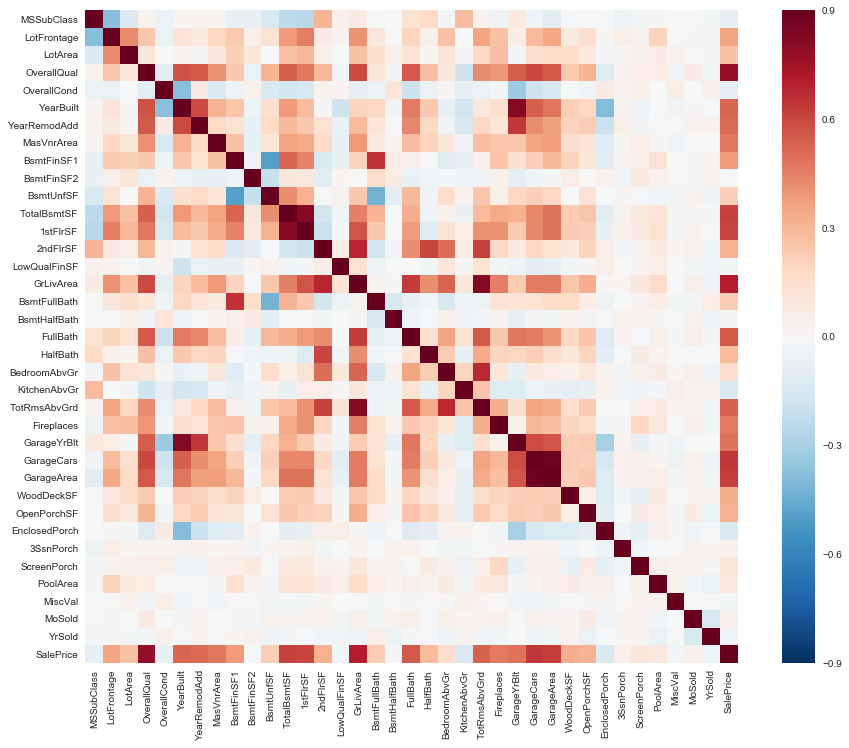

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

corrmat = pd.read_csv('data/train.csv').drop(['Id'], axis=1).corr()
plt.subplots(figsize=(16,12))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

Features which could possibly be removed because they explain nothing

In [11]:
corrmat.loc[(corrmat['SalePrice'] < 0.05) & (corrmat['SalePrice'] > -0.05), 'SalePrice']

BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
Name: SalePrice, dtype: float64

Find highest correlating values and remove them because of the colinearity

In [39]:
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [40]:
X = X.select_dtypes(exclude=['object'])

In [41]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
YearRemodAdd  GarageYrBlt     0.642277
GrLivArea     FullBath        0.630012
2ndFlrSF      TotRmsAbvGrd    0.616423
dtype: float64


In [42]:
top_correlations = get_top_abs_correlations(X, 10)
top_correlations[:5]

GarageCars   GarageArea      0.882475
YearBuilt    GarageYrBlt     0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
2ndFlrSF     GrLivArea       0.687501
dtype: float64

In [18]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y.drop(outliers.index)))

In [44]:
X, y = prepare_inputs(X, y)

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars',
                                                          #'GarageYrBlt',
                                                          'TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [58]:
evaluate_pipeline(X, y)

R2-score: 0.796404422335
RMSE (log): 0.17834854270754444


The performance (r2-score!) is a little weaker if we remove these correlation. This is interesting. What if we drop also variables with no influence to price.

In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars',
                                                          #'GarageYrBlt',
                                                          'TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('remove_low_correlations', DFTransform(lambda X: X.drop(['BsmtFinSF2',
                                                          'LowQualFinSF','BsmtHalfBath','MiscVal', 'YrSold'], axis=1))),
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [60]:
evaluate_pipeline(X, y)

R2-score: 0.796404422335
RMSE (log): 0.17834854270754444


We really could remove this variables. They do not help the model.

### Handling missing input values

In [61]:
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [62]:
X, y = prepare_inputs(X, y)

In [66]:
# Which columns do have null values
X.columns[X.isnull().any(axis=0)]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [69]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

LotFrontage      259
Alley           1365
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

First we handle the numerical features with missing values

#### Numericals

In [148]:
X_numerical = X.select_dtypes(exclude=['object'])
null_columns = X_numerical.columns[X_numerical.isnull().any()]
X_numerical[null_columns].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

##### LotFrontage

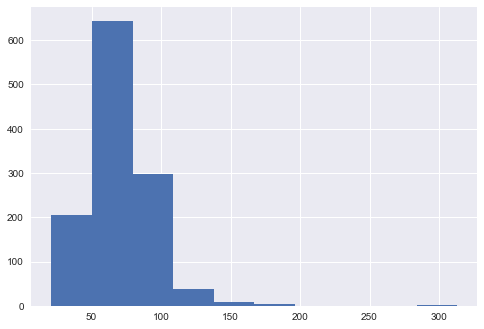

In [71]:
X_numerical['LotFrontage'].hist()

From the documentation we do not know, why there are NaNs with this features. Because there are small other values we could assume that NaNs means there are no streets connected to this properties.

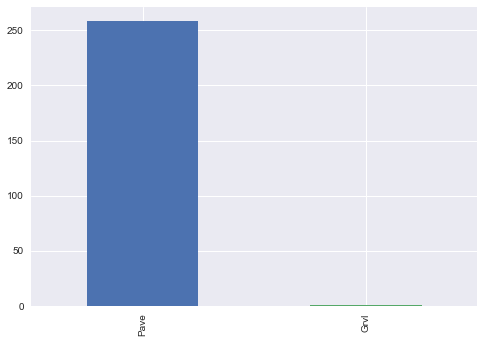

In [80]:
X[X['LotFrontage'].isnull()]['Street'].value_counts().plot(kind='bar')

But the road access does suggest, that there are actually streets. 

In [93]:
X[X['LotFrontage'].isnull()].corr().abs().iloc[0, :].sort_values(ascending=False).head()

MSSubClass     1.000000
GarageYrBlt    0.300610
YearBuilt      0.277406
2ndFlrSF       0.275932
1stFlrSF       0.244767
Name: MSSubClass, dtype: float64

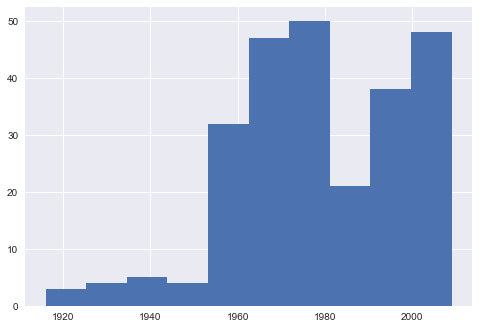

In [97]:
X[X['LotFrontage'].isnull()]['GarageYrBlt'].hist()

They even have a garage, so we fill in the medians.

##### MasVnrArea

In [132]:
X[X['MasVnrArea'].isnull()]['MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

The NaNs in area are corresponding to the NaNs in type. There are not so many of those and we assume we can replace these with 0

In [263]:
def fill_numerical_nans(X_val, mean_columns, zero_columns):
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer = mean_imputer.fit(X_val.loc[:, mean_columns])
    X_new = X_val.copy()
    X_new.loc[:, mean_columns] = mean_imputer.transform(X_val.loc[:, mean_columns])
    X_new.loc[:, zero_columns] = X_new.loc[:, zero_columns].fillna(value=0)
    return X_new

#### GarageYrBlt

This feature will be possibly removed. But we handle the NaNs neverthless so that we are independent

In [144]:
X[X['GarageYrBlt'].isnull()]['GarageType'].head()

39    NaN
48    NaN
78    NaN
88    NaN
89    NaN
Name: GarageType, dtype: object

Corresponds with NaNs in type so we can safely assume there is no garage. We replace the values with 0 - so they are even older than the oldest ones.

In [147]:
X_numerical = X.select_dtypes(exclude=['object'])
X_numerical = fill_numerical_nans(X_numerical, ['LotFrontage'], ['MasVnrArea', 'GarageYrBlt'])

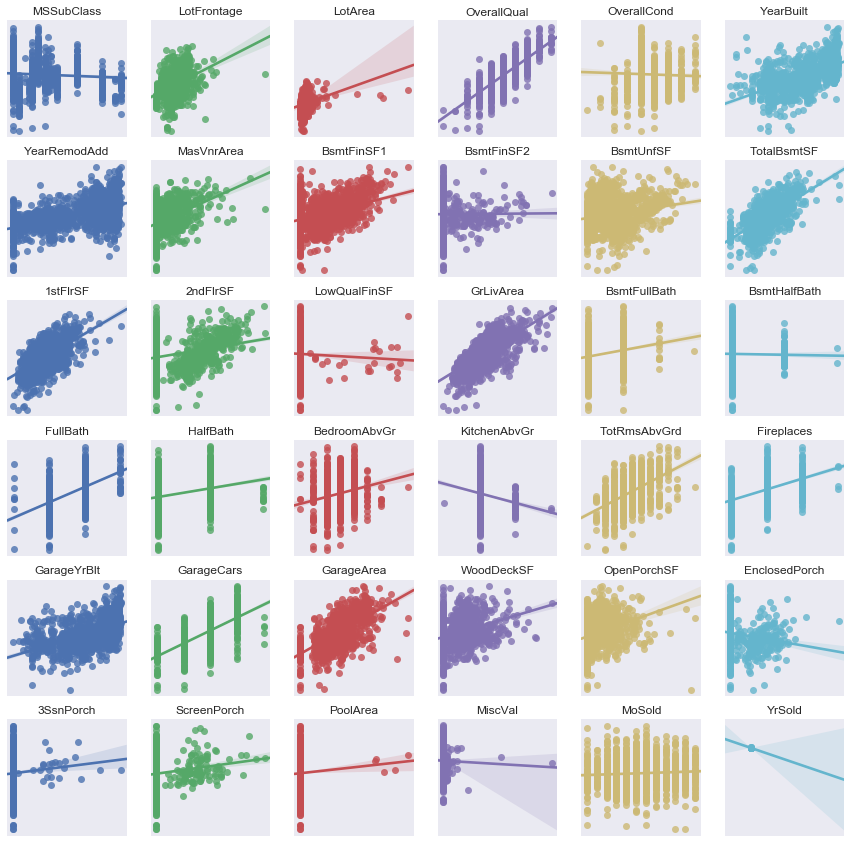

In [171]:
fig, axes = plt.subplots(6,6, figsize=(15,15))
for ax, feature in zip(axes.ravel(), X_numerical.columns):
    ax.set_title(feature)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    sns.regplot(X_numerical[feature], y, ax = ax)
plt.show()

In [551]:
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'

('BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea')

The BsmtXXX are coresponding to no basement and can be replaced with 0 while the GarageCars are corresponding to no Garage and can also be replaced with 0

#### Categoricals

In [150]:
X_categorical = X.select_dtypes(include=['object'])
null_columns = X_categorical.columns[X_categorical.isnull().any()]
X_categorical[null_columns].isnull().sum()

Alley           1365
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans

In [195]:
pd.get_dummies(X_categorical, dummy_na=True, drop_first=True).head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_nan,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [560]:
def create_dummies(X_val):
    return pd.get_dummies(X_val, dummy_na=True, drop_first=True)

But there are nans in the test set which are not in our train set and these are: Index(['Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'MSZoning',
       'SaleType', 'Utilities'],
      dtype='object'). So we need to add these nan columns to our structure. We need to add this to our get_dummies - see below.

So we are now ready to extend our pipeline to all the features

### Simple model with encoded variables and inputed data

In [54]:
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest

In [102]:
def fill_numerical_nans(X_val, mean_columns, zero_columns):
    print('Filling numerical nans...')
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer.fit(X_val.loc[:, mean_columns])
    X_new = X_val.copy()
    X_new.loc[:, mean_columns] = mean_imputer.transform(X_val.loc[:, mean_columns])
    X_new.loc[:, zero_columns] = X_new.loc[:, zero_columns].fillna(value=0)
    return X_new

In [77]:
def get_dummies(X_val):
    print('Creating dummies...')
    print('Starting with input of shape: %s' % str(X_val.shape))
    x_extended = pd.get_dummies(X_val, dummy_na=True, drop_first=True)
    for col in ['Exterior1st_nan', 'Exterior2nd_nan', 'Functional_nan', 'KitchenQual_nan', 
                'MSZoning_nan', 'SaleType_nan', 'Utilities_nan','Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
               'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
               'Exterior2nd_Other', 'GarageQual_Fa', 'Heating_GasA', 'Heating_OthW',
               'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'PoolQC_Fa',
               'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
               'RoofMatl_Roll', 'Utilities_NoSeWa']:
        if col not in x_extended:
            x_extended.loc[:, col] = 0
    x_extended = x_extended[['MSSubClass',
                                 'LotFrontage',
                                 'LotArea',
                                 'OverallQual',
                                 'OverallCond',
                                 'YearBuilt',
                                 'YearRemodAdd',
                                 'MasVnrArea',
                                 'BsmtFinSF1',
                                 'BsmtFinSF2',
                                 'BsmtUnfSF',
                                 'TotalBsmtSF',
                                 '1stFlrSF',
                                 '2ndFlrSF',
                                 'LowQualFinSF',
                                 'GrLivArea',
                                 'BsmtFullBath',
                                 'BsmtHalfBath',
                                 'FullBath',
                                 'HalfBath',
                                 'BedroomAbvGr',
                                 'KitchenAbvGr',
                                 'TotRmsAbvGrd',
                                 'Fireplaces',
                                 'GarageYrBlt',
                                 'GarageCars',
                                 'GarageArea',
                                 'WoodDeckSF',
                                 'OpenPorchSF',
                                 'EnclosedPorch',
                                 '3SsnPorch',
                                 'ScreenPorch',
                                 'PoolArea',
                                 'MiscVal',
                                 'MoSold',
                                 'YrSold',
                                 'MSZoning_FV',
                                 'MSZoning_RH',
                                 'MSZoning_RL',
                                 'MSZoning_RM',
                                 'MSZoning_nan',
                                 'Street_Pave',
                                 'Street_nan',
                                 'Alley_Pave',
                                 'Alley_nan',
                                 'LotShape_IR2',
                                 'LotShape_IR3',
                                 'LotShape_Reg',
                                 'LotShape_nan',
                                 'LandContour_HLS',
                                 'LandContour_Low',
                                 'LandContour_Lvl',
                                 'LandContour_nan',
                                 'Utilities_NoSeWa',
                                 'Utilities_nan',
                                 'LotConfig_CulDSac',
                                 'LotConfig_FR2',
                                 'LotConfig_FR3',
                                 'LotConfig_Inside',
                                 'LotConfig_nan',
                                 'LandSlope_Mod',
                                 'LandSlope_Sev',
                                 'LandSlope_nan',
                                 'Neighborhood_Blueste',
                                 'Neighborhood_BrDale',
                                 'Neighborhood_BrkSide',
                                 'Neighborhood_ClearCr',
                                 'Neighborhood_CollgCr',
                                 'Neighborhood_Crawfor',
                                 'Neighborhood_Edwards',
                                 'Neighborhood_Gilbert',
                                 'Neighborhood_IDOTRR',
                                 'Neighborhood_MeadowV',
                                 'Neighborhood_Mitchel',
                                 'Neighborhood_NAmes',
                                 'Neighborhood_NPkVill',
                                 'Neighborhood_NWAmes',
                                 'Neighborhood_NoRidge',
                                 'Neighborhood_NridgHt',
                                 'Neighborhood_OldTown',
                                 'Neighborhood_SWISU',
                                 'Neighborhood_Sawyer',
                                 'Neighborhood_SawyerW',
                                 'Neighborhood_Somerst',
                                 'Neighborhood_StoneBr',
                                 'Neighborhood_Timber',
                                 'Neighborhood_Veenker',
                                 'Neighborhood_nan',
                                 'Condition1_Feedr',
                                 'Condition1_Norm',
                                 'Condition1_PosA',
                                 'Condition1_PosN',
                                 'Condition1_RRAe',
                                 'Condition1_RRAn',
                                 'Condition1_RRNe',
                                 'Condition1_RRNn',
                                 'Condition1_nan',
                                 'Condition2_Feedr',
                                 'Condition2_Norm',
                                 'Condition2_PosA',
                                 'Condition2_PosN',
                                 'Condition2_RRAe',
                                 'Condition2_RRAn',
                                 'Condition2_RRNn',
                                 'Condition2_nan',
                                 'BldgType_2fmCon',
                                 'BldgType_Duplex',
                                 'BldgType_Twnhs',
                                 'BldgType_TwnhsE',
                                 'BldgType_nan',
                                 'HouseStyle_1.5Unf',
                                 'HouseStyle_1Story',
                                 'HouseStyle_2.5Fin',
                                 'HouseStyle_2.5Unf',
                                 'HouseStyle_2Story',
                                 'HouseStyle_SFoyer',
                                 'HouseStyle_SLvl',
                                 'HouseStyle_nan',
                                 'RoofStyle_Gable',
                                 'RoofStyle_Gambrel',
                                 'RoofStyle_Hip',
                                 'RoofStyle_Mansard',
                                 'RoofStyle_Shed',
                                 'RoofStyle_nan',
                                 'RoofMatl_Membran',
                                 'RoofMatl_Metal',
                                 'RoofMatl_Roll',
                                 'RoofMatl_Tar&Grv',
                                 'RoofMatl_WdShake',
                                 'RoofMatl_WdShngl',
                                 'RoofMatl_nan',
                                 'Exterior1st_AsphShn',
                                 'Exterior1st_BrkComm',
                                 'Exterior1st_BrkFace',
                                 'Exterior1st_CBlock',
                                 'Exterior1st_CemntBd',
                                 'Exterior1st_HdBoard',
                                 'Exterior1st_ImStucc',
                                 'Exterior1st_MetalSd',
                                 'Exterior1st_Plywood',
                                 'Exterior1st_Stone',
                                 'Exterior1st_Stucco',
                                 'Exterior1st_VinylSd',
                                 'Exterior1st_Wd Sdng',
                                 'Exterior1st_WdShing',
                                 'Exterior1st_nan',
                                 'Exterior2nd_AsphShn',
                                 'Exterior2nd_Brk Cmn',
                                 'Exterior2nd_BrkFace',
                                 'Exterior2nd_CBlock',
                                 'Exterior2nd_CmentBd',
                                 'Exterior2nd_HdBoard',
                                 'Exterior2nd_ImStucc',
                                 'Exterior2nd_MetalSd',
                                 'Exterior2nd_Other',
                                 'Exterior2nd_Plywood',
                                 'Exterior2nd_Stone',
                                 'Exterior2nd_Stucco',
                                 'Exterior2nd_VinylSd',
                                 'Exterior2nd_Wd Sdng',
                                 'Exterior2nd_Wd Shng',
                                 'Exterior2nd_nan',
                                 'MasVnrType_BrkFace',
                                 'MasVnrType_None',
                                 'MasVnrType_Stone',
                                 'MasVnrType_nan',
                                 'ExterQual_Fa',
                                 'ExterQual_Gd',
                                 'ExterQual_TA',
                                 'ExterQual_nan',
                                 'ExterCond_Fa',
                                 'ExterCond_Gd',
                                 'ExterCond_Po',
                                 'ExterCond_TA',
                                 'ExterCond_nan',
                                 'Foundation_CBlock',
                                 'Foundation_PConc',
                                 'Foundation_Slab',
                                 'Foundation_Stone',
                                 'Foundation_Wood',
                                 'Foundation_nan',
                                 'BsmtQual_Fa',
                                 'BsmtQual_Gd',
                                 'BsmtQual_TA',
                                 'BsmtQual_nan',
                                 'BsmtCond_Gd',
                                 'BsmtCond_Po',
                                 'BsmtCond_TA',
                                 'BsmtCond_nan',
                                 'BsmtExposure_Gd',
                                 'BsmtExposure_Mn',
                                 'BsmtExposure_No',
                                 'BsmtExposure_nan',
                                 'BsmtFinType1_BLQ',
                                 'BsmtFinType1_GLQ',
                                 'BsmtFinType1_LwQ',
                                 'BsmtFinType1_Rec',
                                 'BsmtFinType1_Unf',
                                 'BsmtFinType1_nan',
                                 'BsmtFinType2_BLQ',
                                 'BsmtFinType2_GLQ',
                                 'BsmtFinType2_LwQ',
                                 'BsmtFinType2_Rec',
                                 'BsmtFinType2_Unf',
                                 'BsmtFinType2_nan',
                                 'Heating_GasA',
                                 'Heating_GasW',
                                 'Heating_Grav',
                                 'Heating_OthW',
                                 'Heating_Wall',
                                 'Heating_nan',
                                 'HeatingQC_Fa',
                                 'HeatingQC_Gd',
                                 'HeatingQC_Po',
                                 'HeatingQC_TA',
                                 'HeatingQC_nan',
                                 'CentralAir_Y',
                                 'CentralAir_nan',
                                 'Electrical_FuseF',
                                 'Electrical_FuseP',
                                 'Electrical_Mix',
                                 'Electrical_SBrkr',
                                 'Electrical_nan',
                                 'KitchenQual_Fa',
                                 'KitchenQual_Gd',
                                 'KitchenQual_TA',
                                 'KitchenQual_nan',
                                 'Functional_Maj2',
                                 'Functional_Min1',
                                 'Functional_Min2',
                                 'Functional_Mod',
                                 'Functional_Sev',
                                 'Functional_Typ',
                                 'Functional_nan',
                                 'FireplaceQu_Fa',
                                 'FireplaceQu_Gd',
                                 'FireplaceQu_Po',
                                 'FireplaceQu_TA',
                                 'FireplaceQu_nan',
                                 'GarageType_Attchd',
                                 'GarageType_Basment',
                                 'GarageType_BuiltIn',
                                 'GarageType_CarPort',
                                 'GarageType_Detchd',
                                 'GarageType_nan',
                                 'GarageFinish_RFn',
                                 'GarageFinish_Unf',
                                 'GarageFinish_nan',
                                 'GarageQual_Fa',
                                 'GarageQual_Gd',
                                 'GarageQual_Po',
                                 'GarageQual_TA',
                                 'GarageQual_nan',
                                 'GarageCond_Fa',
                                 'GarageCond_Gd',
                                 'GarageCond_Po',
                                 'GarageCond_TA',
                                 'GarageCond_nan',
                                 'PavedDrive_P',
                                 'PavedDrive_Y',
                                 'PavedDrive_nan',
                                 'PoolQC_Fa',
                                 'PoolQC_Gd',
                                 'PoolQC_nan',
                                 'Fence_GdWo',
                                 'Fence_MnPrv',
                                 'Fence_MnWw',
                                 'Fence_nan',
                                 'MiscFeature_Othr',
                                 'MiscFeature_Shed',
                                 'MiscFeature_TenC',
                                 'MiscFeature_nan',
                                 'SaleType_CWD',
                                 'SaleType_Con',
                                 'SaleType_ConLD',
                                 'SaleType_ConLI',
                                 'SaleType_ConLw',
                                 'SaleType_New',
                                 'SaleType_Oth',
                                 'SaleType_WD',
                                 'SaleType_nan',
                                 'SaleCondition_AdjLand',
                                 'SaleCondition_Alloca',
                                 'SaleCondition_Family',
                                 'SaleCondition_Normal',
                                 'SaleCondition_Partial',
                                 'SaleCondition_nan',
                                 'RoofMatl_CompShg']]
    print('Returning output of shape: %s' % str(x_extended.shape))
    return x_extended

In [57]:
def plot_benchmark(X_t, y_t, pred):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    axes[0].scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.4)
    axes[0].set_title('Baseline vs Predictions')
    axes[0].scatter(X_t['GrLivArea'], np.expm1(pred), alpha=.4)
    axes[1].set_title('Baseline vs Predictions')
    axes[1].hist(y_t, alpha=.3)
    axes[1].hist(pred, alpha=.6)
    plt.show()
    print_benchmark(y_t, pred)

In [58]:
train_df = pd.read_csv('data/train.csv')

In [59]:
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']

In [60]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y.drop(outliers.index)))

In [61]:
X, y = prepare_inputs(X, y)

In [81]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X_a: fill_numerical_nans(X_a, ['LotFrontage'], ['MasVnrArea', 
                                                                                            'GarageYrBlt',
                                                                                            'BsmtFinSF1',
                                                                                            'BsmtFinSF2',
                                                                                            'BsmtUnfSF',
                                                                                            'TotalBsmtSF',
                                                                                            'BsmtFullBath',
                                                                                            'BsmtHalfBath',
                                                                                            'GarageCars',
                                                                                            'GarageArea']))),
    ('encode_dummies', DFTransform(lambda X_a: get_dummies(X_a)))
])

In [63]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [82]:
pipeline = Pipeline([
    ('lin_reg', LinearRegression())
])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [67]:
predictions = pipeline.predict(X_test)

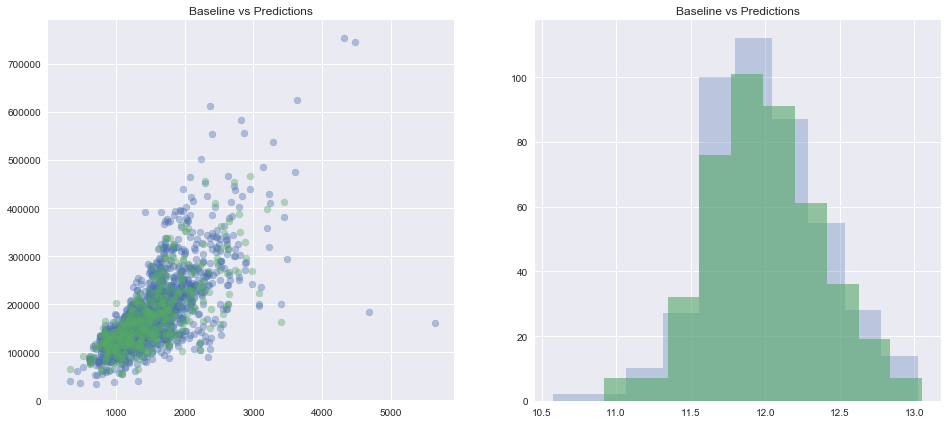

R2-score: 0.867192915026
RMSE (log): 0.1403652639948691


In [68]:
plot_benchmark(X_test, y_test, predictions)

Make the predictions for the test set. But first we want to train on the whole set without train and test split

In [69]:
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)
X = trans_pipeline.fit_transform(X)
pipeline.fit(X, y)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [70]:
test_df = pd.read_csv('data/test.csv')
X = test_df.drop(['Id'], axis=1)
X = trans_pipeline.transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1459, 79)
Returning output of shape: (1459, 288)


In [71]:
predictions = pipeline.predict(X)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 157335.28
Difference in means is: -23585.9177049
IMPORTANT: There is something wrong with your predictions!!!


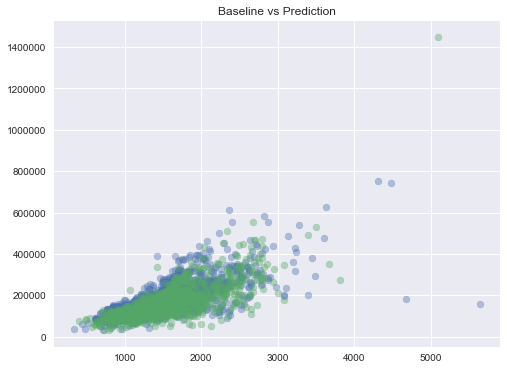

In [73]:
draw_sanity_check(predictions, False)

In [27]:
write_submission(test_df, np.expm1(predictions))

File written to C:\Source\predicting-house-prices\submissions\20180721204847.csv


Kaggle score: 0.21469

### Building a better pipeline with cross validation

In [98]:
def rsme_log(y_actual, y_predicted):
    return math.sqrt(mean_squared_error(y_actual, y_predicted))

In [91]:
from sklearn.metrics import make_scorer

In [92]:
train_df = pd.read_csv('data/train.csv')
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)

In [93]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [100]:
from sklearn.cross_validation import cross_val_score
scorer = make_scorer(rsme_log)
cross_val_score(pipeline, X, y, cv=5, scoring=scorer)

array([ 0.12468363,  0.13696554,  0.14420381,  0.10996149,  0.12675848])

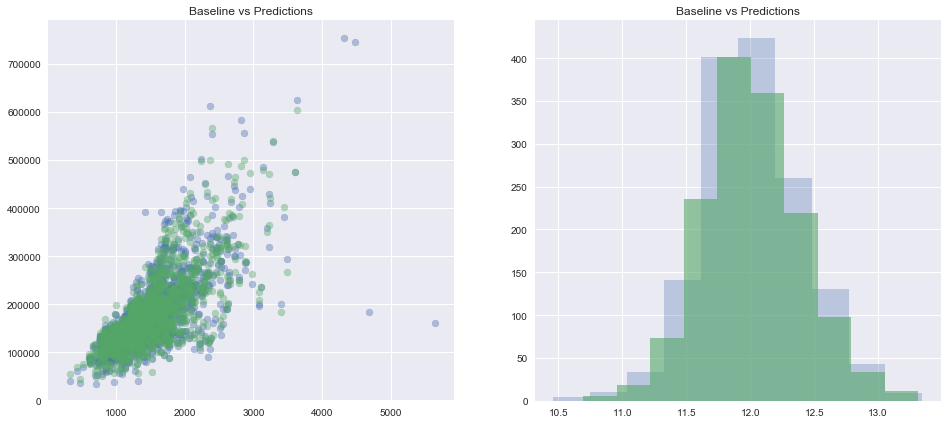

R2-score: 0.947845293788
RMSE (log): 0.0904226972302732


In [101]:
pipeline.fit(X, y)
predictions = pipeline.predict(X)
plot_benchmark(X, y, predictions)

This naturally is overfitted because we have done no split. But cross validation does not help us very much.

### Optimizing our dummy variable converter and using LabelEncoder

Some special cases of our categorical features need to be handles first

In [360]:
def impute_special_cases(X_val):
    X_new = X_val.copy()
    
    # According to documentation
    X_new['Functional'] = X_new['Functional'].fillna('Typ')
    
    # Some features we inpute with the mode because NaN/None makes no sense
    for col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
        X_new[col] = X_new[col].fillna(value=X_new[col].mode()[0])

    return X_new

In [361]:
def drop_features(X_val):
    return X_val.drop(['Utilities'], axis=1)

In [362]:
def fill_numerical_nans(X_val):
    mean_columns = ['LotFrontage']
    zero_columns = ['MasVnrArea', 
                    'GarageYrBlt',
                    'BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath',
                    'BsmtHalfBath',
                    'GarageCars',
                    'GarageArea']
    X_new = X_val.copy()
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer.fit(X_new.loc[:, mean_columns])
    X_new.loc[:, mean_columns] = mean_imputer.transform(X_new.loc[:, mean_columns])
    X_new.loc[:, zero_columns] = X_new.loc[:, zero_columns].fillna(value=0)
    return X_new

In [381]:
def create_dummies(X_val):
    print('Creating dummies...')
    print('Starting with input of shape: %s' % str(X_val.shape))
    X_new = X_val.copy()
    x_extended = pd.get_dummies(X_val, dummy_na=True, drop_first=True)
    print('Returning output of shape: %s' % str(x_extended.shape))
    return x_extended

Ordinal features need to be converted with label encoder

In [382]:
from sklearn.preprocessing import LabelEncoder
def encode_ordinals(X_val):
    X_new = X_val.copy()
    for col in ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']:
        encoder = LabelEncoder()
        encoder.fit(list(X_val[col].values))
        X_new[col] = encoder.transform(list(X_val[col].values))
    return X_new

In [383]:
def impute_categorical(X_val):
    X_new = X_val.copy()
    for col in ['MasVnrType', 'GarageType', 'MiscFeature']:
        X_new[col] = X_new[col].fillna('None')
    return X_new

In [402]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
])

### Changing to transform all data at once - only way this can work

In [456]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)

In [457]:
X_train, y_train = prepare_inputs(X_train, y_train)
X_train.shape

(1456, 79)

In [458]:
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 

In [459]:
X_tranformed = trans_pipeline.fit_transform(X_combined)

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [460]:
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

In [461]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)

In [462]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [463]:
predictions = pipeline.predict(X_test)

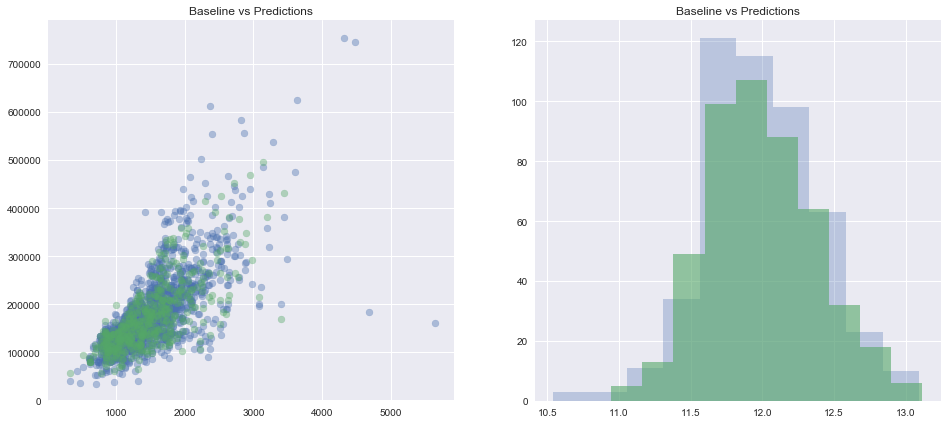

R2-score: 0.883987658729
RMSE (log): 0.1346286499098431


In [464]:
plot_benchmark(X_test, y_test, predictions)

### Automating pipeline, training, prediction and submission

In [397]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y_val.drop(outliers.index)))

In [278]:
def train_pipeline(transformation_pipeline, estimation_pipeline):
    print('Loading training data...')
    train_df = pd.read_csv('data/train.csv')
    X = train_df.drop(['SalePrice','Id'], axis=1)
    y = train_df['SalePrice']
    X, y = prepare_inputs(X, y)
    print('Transforming input...')
    X = transformation_pipeline.fit_transform(X)
    print('Create train/test split')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
    estimation_pipeline.fit(X_train, y_train)
    print('Create predictions...')
    predictions = estimation_pipeline.predict(X_test)
    plot_benchmark(X_test, y_test, predictions)
    return (transformation_pipeline, estimation_pipeline)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Create train/test split
Create predictions...


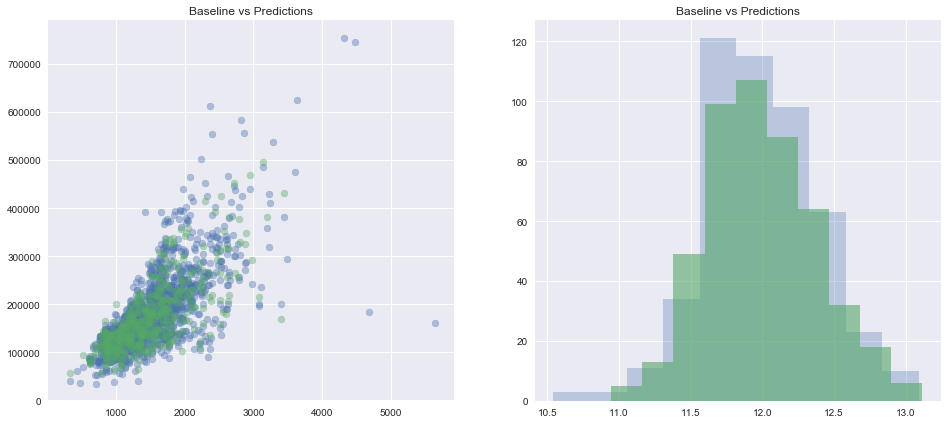

R2-score: 0.884226775902
RMSE (log): 0.13448983438863013


In [279]:
(trans_p, fit_p) = train_pipeline(Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ]), 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

And now also make a method for the execution of the pipeline:

In [301]:
def execute_pipeline(transformation_pipeline, fitted_pipeline):
    test_df = pd.read_csv('data/test.csv')
    X = test_df.drop(['Id'], axis=1)
    X = transformation_pipeline.fit_transform(X)    
    predictions = fitted_pipeline.predict(X)
    draw_sanity_check(predictions, False)
    return predictions

Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 138525.19
Difference in means is: -42396.0096964
IMPORTANT: There is something wrong with your predictions!!!


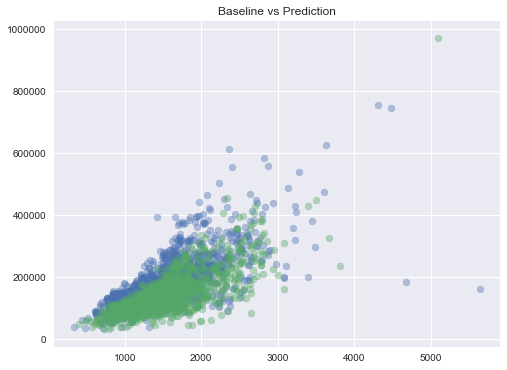

In [302]:
predictions = execute_pipeline(trans_p, fit_p)

In [317]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180722112246.csv


### Trying to find the features that makes the predictions to low

In [330]:
all_features = ['MSSubClass',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_BrkFace',
 'Exterior2nd_CBlock',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Other',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Wd Shng',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_None',
 'MiscFeature_None',
 'MiscFeature_Othr',
 'MiscFeature_Shed',
 'MiscFeature_TenC',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_New',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial',
 'GarageQual_Fa',
 'PoolQC_Fa',
 'RoofMatl_CompShg']

In [348]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

tp = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

fp = Pipeline([
    ('lin_reg', LinearRegression())
])



differences = []
for i in range(1, len(all_features)):
    
    X_train = train_df.drop(['SalePrice', 'Id'], axis=1)
    y_train = train_df['SalePrice']
    X_train, y_train = prepare_inputs(X_train, y_train)

    X_test = test_df.drop(['Id'], axis=1)
    
    # training
    X_train = tp.fit_transform(X_train)
    X_train = X_train[all_features[:i]]
    fp.fit(X_train, y_train)
    
    # predicting
    X_test = tp.fit_transform(X_test)
    X_test = X_test[all_features[:i]]
    predictions = np.expm1(fp.predict(X_test))
    difference = predictions.mean() - train_df['SalePrice'].mean()
    #print('Features: %s' % all_features[:i])
    print('-------> Difference in means is: %s' % difference)
    differences.append(difference)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -14612.9677851
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -14082.274914
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -14587.2153252
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -14512.5098276
Creating 

Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -1728.21671447
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -1648.38398677
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -1624.66790106
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -1751.00879306
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating

Returning output of shape: (1459, 202)
-------> Difference in means is: -39975.8355366
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -40025.0819541
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -40014.071196
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -40026.2793847
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning

Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -34320.808178
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -34025.9226412
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -34000.386603
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -33884.9547805
Creating dummies...
Starting w

Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -33965.569428
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -33945.0778789
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -33708.875836
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -33706.6622259
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating d

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -39900.3501492
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -49046.4050484
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -37941.8988915
Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -35641.6283854
Creating

Returning output of shape: (1456, 202)
Creating dummies...
Starting with input of shape: (1459, 78)
Returning output of shape: (1459, 202)
-------> Difference in means is: -44947.3342041


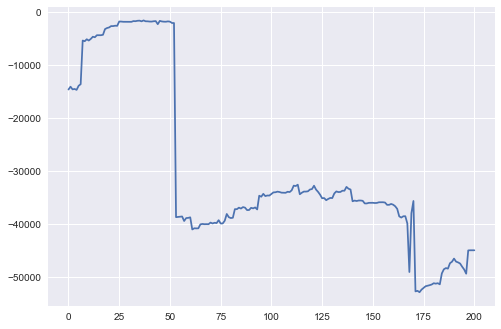

In [349]:
import matplotlib.pyplot as plt
plt.plot(differences)
plt.show()

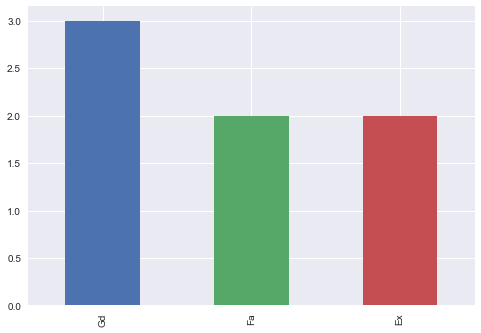

In [356]:
train_df['PoolQC'].value_counts().plot(kind='bar')

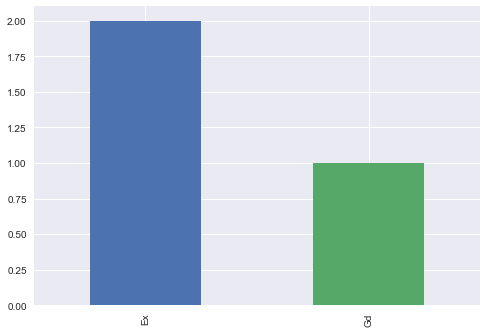

In [359]:
test_df['PoolQC'].value_counts().plot(kind='bar')

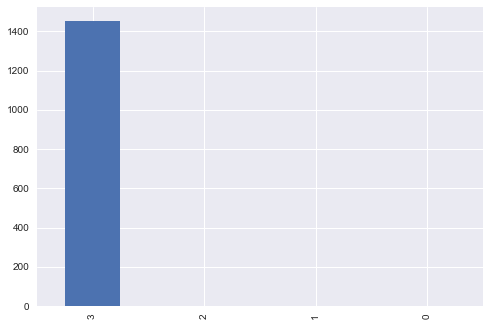

In [354]:
X_train['PoolQC'].value_counts().plot(kind='bar')

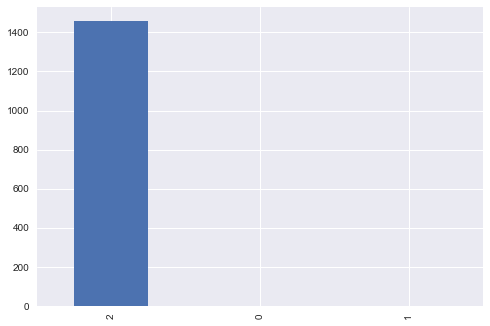

In [355]:
X_test['PoolQC'].value_counts().plot(kind='bar')